In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression


EVO = pd.read_csv('/data/EVO.csv')

In [4]:
#Analsiis dataframe
EVO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61368 entries, 0 to 61367
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dia               61368 non-null  object 
 1   Tm                61355 non-null  float64
 2   Tmax              61363 non-null  float64
 3   Tmin              61364 non-null  float64
 4   Velocitat_vent    61368 non-null  float64
 5   HRmd              61356 non-null  float64
 6   HRmax             61363 non-null  float64
 7   Precipitacio      61368 non-null  float64
 8   Irradiacio_solar  61361 non-null  float64
 9   ETo               61216 non-null  float64
 10  Clima             61368 non-null  object 
 11  Lat               61368 non-null  float64
 12  EMA               61368 non-null  object 
 13  Any               61368 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 6.6+ MB


In [11]:
# Eliminacio nulls. Seguretat
EVO.dropna(inplace=True)
EVO.reset_index(drop=True, inplace=True)

EVO['Dia'] = pd.to_datetime(EVO['Dia'])
#Creació variable dia de l'any, per creació variable ciclica que s'incorporarà al model
EVO['D'] = EVO['Dia'].dt.dayofyear
EVO['Dia_sin'] = np.sin(2 * np.pi * EVO['D'] / 365.0)
EVO['Dia_cos'] = np.cos(2 * np.pi * EVO['D'] / 365.0)

In [12]:
# Analsiis dataframe
EVO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61216 entries, 0 to 61215
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Dia               61216 non-null  datetime64[ns]
 1   Tm                61216 non-null  float64       
 2   Tmax              61216 non-null  float64       
 3   Tmin              61216 non-null  float64       
 4   Velocitat_vent    61216 non-null  float64       
 5   HRmd              61216 non-null  float64       
 6   HRmax             61216 non-null  float64       
 7   Precipitacio      61216 non-null  float64       
 8   Irradiacio_solar  61216 non-null  float64       
 9   ETo               61216 non-null  float64       
 10  Clima             61216 non-null  object        
 11  Lat               61216 non-null  float64       
 12  EMA               61216 non-null  object        
 13  Any               61216 non-null  int64         
 14  D                 6121

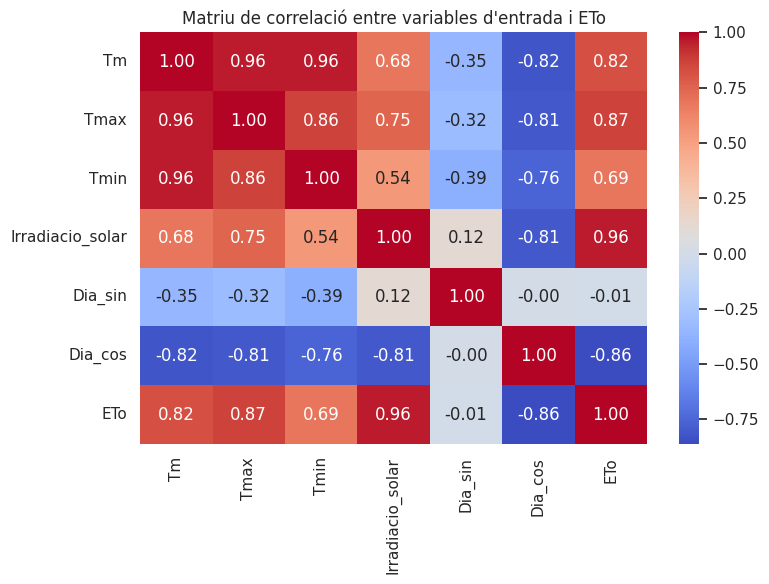

In [13]:

# Matriu de Correlació

sns.set(style="whitegrid")


variables = ['Tm', 'Tmax', 'Tmin', 'Irradiacio_solar', 'Dia_sin', 'Dia_cos', 'ETo']

# Càlcul de la matriu de correlació
correlation_matrix = EVO[variables].corr()

# Visualització
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriu de correlació entre variables d'entrada i ETo")
plt.tight_layout()
plt.show()

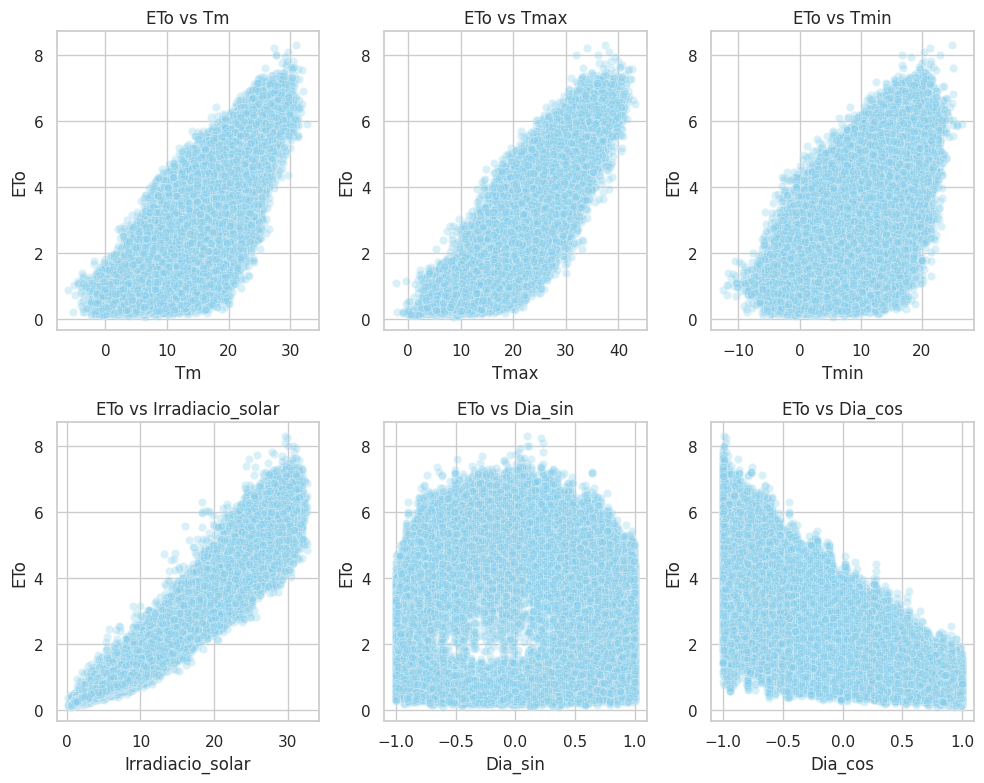

In [14]:

sns.set(style="whitegrid")

# Selecció de les variables meteorologiques EMA
variables = ['Tm', 'Tmax', 'Tmin', 'Irradiacio_solar', 'Dia_sin', 'Dia_cos']

# Gràfics de dispersió entre variables
plt.figure(figsize=(10,8))
sns.set(style="whitegrid")


num_vars = len(variables)
num_rows = int(np.ceil(num_vars / 3))
num_cols = 3

for i, var in enumerate(variables, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(data=EVO, x=var, y='ETo', alpha=0.3, color='skyblue')
    plt.title(f'ETo vs {var}')
    plt.xlabel(var)
    plt.ylabel('ETo')

plt.tight_layout()
plt.show()

In [15]:
# Selecció de caracteristiques


EVO_cleaned = EVO.dropna(subset=['ETo'])

# Variables independents (X) i dependent (y)
X = EVO_cleaned[['Tm', 'Tmax', 'Tmin', 'Irradiacio_solar', 'Lat']]
y = EVO_cleaned['ETo']

X = X.fillna(X.mean())

# Avaluació univariada amb test F
f_scores, p_values = f_regression(X, y)

# Resultats en un DataFrame
feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False)

print(feature_importance)

           Variable        F_score       p_value
3  Irradiacio_solar  770869.322740  0.000000e+00
1              Tmax  182084.554113  0.000000e+00
0                Tm  124107.865480  0.000000e+00
2              Tmin   54452.168853  0.000000e+00
4               Lat     162.398205  3.775386e-37


In [10]:
#ANOVA variable categòrica Clima
EVO_cleaned_for_analysis = EVO.dropna(subset=['ETo'])

categorical_vars_to_analyze = ['Clima']

for cat_var in categorical_vars_to_analyze:
    formula = f'ETo ~ C({cat_var})'
    model = ols(formula, data=EVO_cleaned_for_analysis).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA for '{cat_var}':")
    print(anova_table)


ANOVA for 'Clima':
                 sum_sq       df         F         PR(>F)
C(Clima)    1630.970973     11.0  47.52477  1.298518e-104
Residual  190947.217050  61204.0       NaN            NaN
